### Visualization Performance


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import itertools
from matplotlib import pyplot as plt
import matplotlib.dates as mdate
import matplotlib.dates as mdates
import glob
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from utility.utility import *
from utility.techIndex import talib_index
from utility.model import dnn, lstm, conv1d, conv2d, transformer

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [2]:
# get last weight
newest = True

test_weight = {
    # 'transformer': '',
    # 'conv1d': '',
    # 'conv2d': '',
    # 'dnn': '',
    'lstm': ''
 }
# # test data
# stock = 'TWII_test.csv'

if newest:
    for model, folder in test_weight.items(): 
        # test_weight[model] = glob.glob(f'model/{model}/*/')[-1][:-1]
        test_weight[model] = glob.glob(f'model/{model}/*.index')[-1][:-6]

# window length
# slide = 30

df = read_data(config, 'test')
model_metric = {}
test_weight

data\NFLX_test.csv


{'lstm': 'model/lstm\\20221005-234739_NFLX_e20_s30'}

### Predict Price

In [3]:
%%time

X, y = label(df)
# X_dim = X.index
X_scaler, y_scaler = scaler(X, y, config, 'test')
# sns.set_palette("tab10")
metric = pd.DataFrame()
# metric = pd.DataFrame({'bench mark':y[int(config['MODEL']['slide']):]})
metric = pd.DataFrame(y_scaler[int(config['MODEL']['slide']):], index = y.index[int(config['MODEL']['slide']):], columns = 'bench mark')
# metric['bench mark'] = y_scaler.reshape(1,-1)

for model_name, weight in test_weight.items(): 
    X_, y_ = training_window(X_scaler, y_scaler , config, model_name)
    model = load_model(X_.shape, model_name)
    model.load_weights(test_weight[model_name])
    y_pred = model.predict(X_)

    # if bool(config["STOCK"]["scale"]):
    #     y_pred = inverse_predict(y_pred, config)
    # mse = mean_squared_error(y[int(config['MODEL']['slide']):], y_pred, squared=False)   
    metric[model_name] = y_pred
    print('7')
    
display(metric)




scale

3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           69120     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 200,833
Trainable params: 200,833
Non-trainable params: 0
_________________________________________________________________
None
4
5
5/5 [==============================] - 1s 15ms/step
6
7


,0,lstm
Date,,
2022-02-16,1.163046,1.140269
2022-02-17,1.111697,1.075347
2022-02-18,1.049234,1.056391
2022-02-22,1.074526,1.082684
2022-02-23,0.998377,1.008549
...,...,...
2022-09-28,0.160686,0.214360
2022-09-29,0.274772,0.240201
2022-09-30,0.244718,0.261898


CPU times: total: 1.02 s
Wall time: 1.11 s


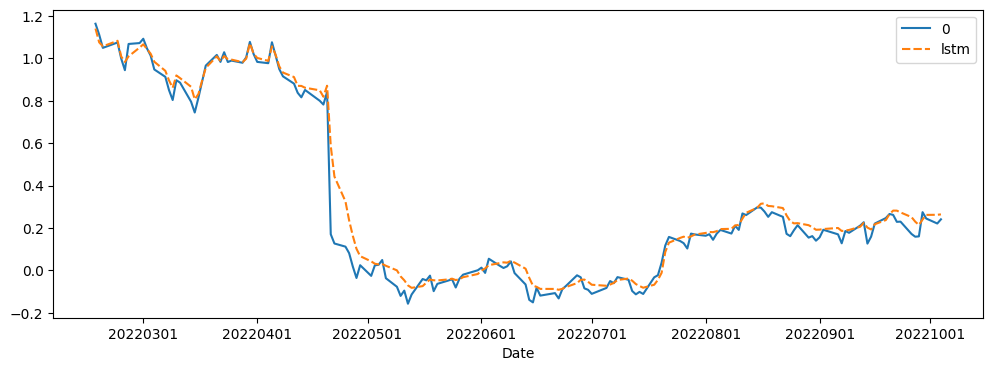

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
metric.index = pd.to_datetime(metric.index)
sns.lineplot(data=metric, ax=ax)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
